# Dataset & Dataloader

### Dataset

In [1]:
import os
import torchio as tio

In [18]:
def create_synthrad_dataset(root_dir):
    """
    Create a TorchIO SubjectsDataset for SynthRAD2023 Task 1 (MRI→CT).

    Args:
        root_dir (str): Path to the Task1 directory, e.g. './SynthRAD2023/Task1'
    Returns:
        tio.SubjectsDataset: TorchIO dataset containing (mr, ct, mask)
    """

    subjects = []

    # Each subfolder (AB, HN, TH)
    for anatomy in sorted(os.listdir(root_dir)):
        anatomy_path = os.path.join(root_dir, anatomy)
        if not os.path.isdir(anatomy_path):
            continue

        # Each patient folder, e.g. 1HNA001
        for patient in sorted(os.listdir(anatomy_path)):
            patient_path = os.path.join(anatomy_path, patient)
            if not os.path.isdir(patient_path):
                continue

            mr_path = os.path.join(patient_path, "mr.nii")
            ct_path = os.path.join(patient_path, "ct.nii")
            mask_path = os.path.join(patient_path, "mask.nii")

            # Verify existence
            if not (os.path.exists(mr_path) and os.path.exists(ct_path)):
                continue
            subject = tio.Subject(
                id=patient,
                anatomy=anatomy,
                mr=tio.ScalarImage(mr_path),
                ct=tio.ScalarImage(ct_path),
                mask=tio.LabelMap(mask_path),
            )

            subjects.append(subject)

    # Define preprocessing/augmentation transforms
    # transform = tio.Compose([
    #     tio.Resample((1.0, 1.0, 1.0)),       # resample to 1mm isotropic voxels
    #     tio.ZNormalization(),                 # normalize MRI intensity
    #     tio.RandomFlip(axes=(0, 1, 2)),       # random flipping
    # ])
    # dataset = tio.SubjectsDataset(subjects, transform=transform)
    dataset = tio.SubjectsDataset(subjects)
    return dataset


### Dataloader

In [ ]:
from torch.utils.data import DataLoader

root = "/Users/ms/cs/ML/MRI2CT/SynthRAD2023/Task1"
dataset = create_synthrad_dataset(root)
print(f"Total cases: {len(dataset)}")

loader = DataLoader(dataset, batch_size=1, shuffle=True)
# 890 * 0.65 = 578
# 578 - center D samples

Total cases: 360


In [ ]:
from collections import Counter

counts = Counter([subj["anatomy"] for subj in dataset])
print(counts)

Counter({'brain': 180, 'pelvis': 180})


In [21]:
batch = next(iter(loader))
print("MRI shape:", batch["mr"][tio.DATA].shape)
print("CT shape:", batch["ct"][tio.DATA].shape)
print("Mask shape:", batch["mask"][tio.DATA].shape)

MRI shape: torch.Size([1, 1, 481, 309, 135])
CT shape: torch.Size([1, 1, 481, 309, 135])
Mask shape: torch.Size([1, 1, 481, 309, 135])


In [ ]:
# Access a single Subject (not batched)
subject = dataset[0]

print("MRI spacing:", subject["mr"].spacing)
print("CT spacing:", subject["ct"].spacing)
print("MRI orientation:", subject["mr"].orientation)
print("CT orientation:", subject["ct"].orientation)

MRI spacing: (1.0, 1.0, 1.0)
CT spacing: (1.0, 1.0, 1.0)
MRI orientation: ('L', 'P', 'S')
CT orientation: ('L', 'P', 'S')


#### Train/Val/Test split dataloader

In [ ]:
from torch.utils.data import random_split, DataLoader
import torch

# --- Split ratios ---
train_ratio, val_ratio, test_ratio = 0.65, 0.10, 0.25
n_total = len(dataset)
n_train = int(train_ratio * n_total)
n_val = int(val_ratio * n_total)
n_test = n_total - n_train - n_val

# --- Random split ---
train_ds, val_ds, test_ds = random_split(
    dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# --- Dataloaders ---
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

Train: 234 | Val: 36 | Test: 90


In [ ]:
print("Example IDs:")
print("Train:", train_ds[0]["id"])
print("Val:", val_ds[0]["id"])
print("Test:", test_ds[0]["id"])

Example IDs:
Train: 1PA074
Val: 1PA171
Test: 1BA359


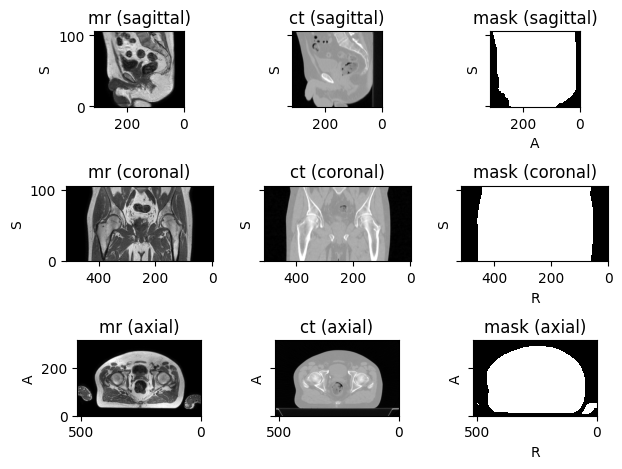

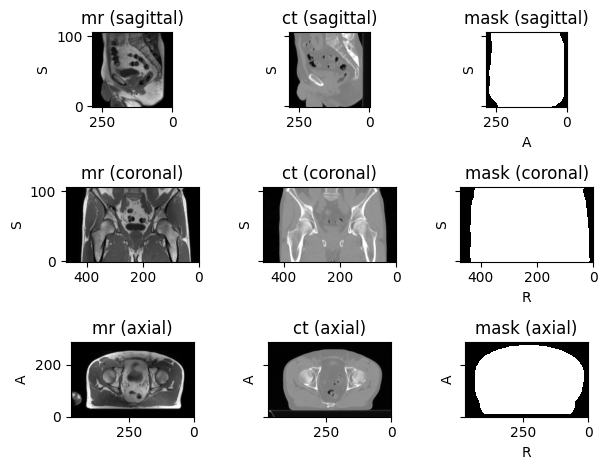

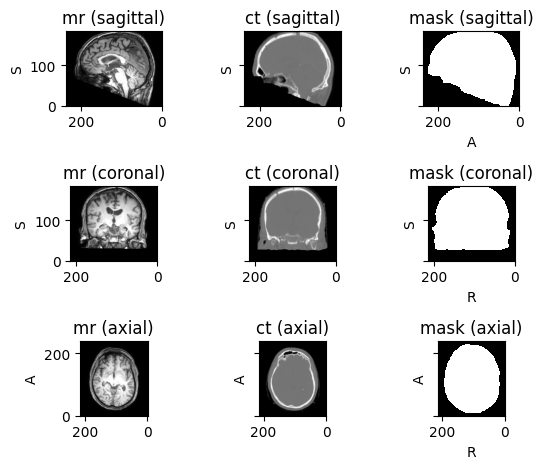

In [25]:
train_ds[0].plot()
val_ds[0].plot()
test_ds[0].plot()

### Visualization

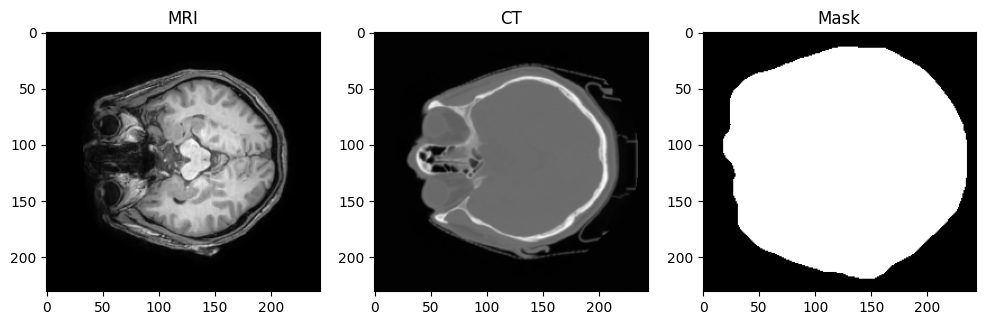

In [ ]:
import matplotlib.pyplot as plt
import torchio as tio

subject = dataset[0]
mr = subject["mr"].data[0]
ct = subject["ct"].data[0]
mask = subject["mask"].data[0]

# Pick middle slice along z-axis
z = mr.shape[-1] // 2

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(mr[..., z], cmap="gray")
plt.title("MRI")

plt.subplot(1, 3, 2)
plt.imshow(ct[..., z], cmap="gray")
plt.title("CT")

plt.subplot(1, 3, 3)
plt.imshow(mask[..., z], cmap="gray")
plt.title("Mask")

plt.show()

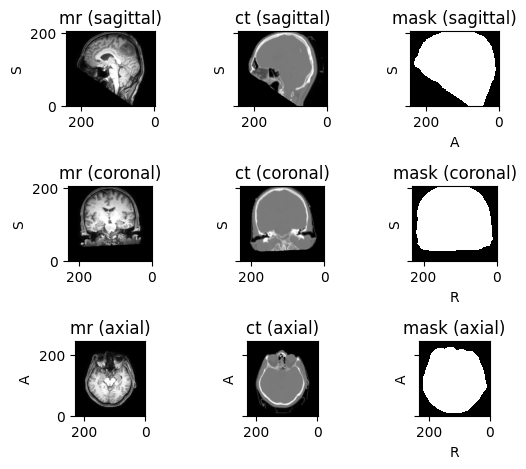

In [27]:
# Central sagittal, coronal, axial slices
subject.plot()

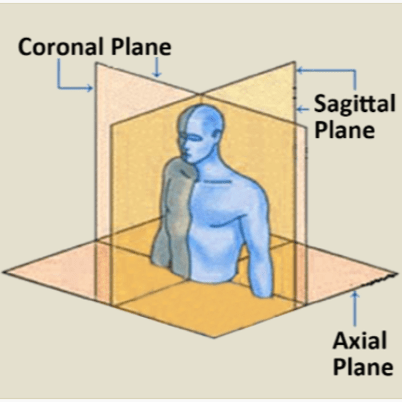

# Training

In [28]:
# from monai.networks.nets import UNet
from monai.networks.nets.unet import UNet
from torch.nn import L1Loss
import torch

/Users/ms/anaconda3/envs/mri2ct/lib/python3.10/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


In [ ]:
# Example configuration for 3D MRI→CT mapping
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),  # feature map sizes per layer
    strides=(2, 2, 2, 2),  # downsampling ratios
).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = L1Loss()

for batch in loader:
    mr = batch["mr"][tio.DATA].cuda()
    ct = batch["ct"][tio.DATA].cuda()

    pred = model(mr)
    loss = loss_fn(pred, ct)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("Train loss:", loss.item())

# Change to .nii.gz

In [1]:
import os
import SimpleITK as sitk
from tqdm import tqdm

DATA_DIR_ROOT = "/scratch/jjparkcv_root/jjparkcv98/minsukc/"
root = os.path.join(DATA_DIR_ROOT, "SynthRAD2023/Task1")

# Collect all .nii file paths
nii_files = []
for anatomy in sorted(os.listdir(root)):  # brain, pelvis, etc.
    anatomy_path = os.path.join(root, anatomy)
    if not os.path.isdir(anatomy_path):
        continue

    for patient in sorted(os.listdir(anatomy_path)):
        patient_path = os.path.join(anatomy_path, patient)
        if not os.path.isdir(patient_path):
            continue

        for name in ["mr.nii", "ct.nii", "mask.nii"]:
            nii_path = os.path.join(patient_path, name)
            if os.path.exists(nii_path):
                nii_files.append(nii_path)

print(f"🔍 Found {len(nii_files)} .nii files to compress.")

# Convert to .nii.gz
for nii_path in tqdm(nii_files, desc="Compressing .nii → .nii.gz"):
    gz_path = nii_path + ".gz"  # e.g., mr.nii → mr.nii.gz
    if not os.path.exists(gz_path):
        img = sitk.ReadImage(nii_path)
        sitk.WriteImage(img, gz_path)

🔍 Found 1080 .nii files to compress.


Compressing .nii → .nii.gz: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1080/1080 [24:13<00:00,  1.35s/it]


In [ ]:
# .mha --> .nii.gz

root = os.path.join(DATA_DIR_ROOT, "SynthRAD2025/Task1")

# Collect all mha paths first
mha_files = []
for anatomy in sorted(os.listdir(root)):  # AB, HN, TH
    anatomy_path = os.path.join(root, anatomy)
    if not os.path.isdir(anatomy_path):
        continue

    for patient in sorted(os.listdir(anatomy_path)):
        patient_path = os.path.join(anatomy_path, patient)
        if not os.path.isdir(patient_path):
            continue

        for name in ["mr.mha", "ct.mha", "mask.mha"]:
            mha_path = os.path.join(patient_path, name)
            if os.path.exists(mha_path):
                mha_files.append(mha_path)

print(f"🔍 Found {len(mha_files)} .mha files to check.")

# Convert with tqdm
for mha_path in tqdm(mha_files, desc="Converting .mha → .nii.gz"):
    nii_path = mha_path.replace(".mha", ".nii.gz")

    if not os.path.exists(nii_path):
        img = sitk.ReadImage(mha_path)
        sitk.WriteImage(img, nii_path)